In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import json
import plotly.express as px

In [2]:
df = pd.read_excel('../data/raw/farm_site_boundary.xlsx')

In [3]:
def string_to_polygon(s):
    # Replace single quotes with double quotes for valid JSON format
    s = s.replace("'", '"')
    # Turn the string into a list of point dictionaries
    points_list = eval(s)
    # Create a Polygon object from the list of point dictionaries
    polygon = Polygon([(point['lng'], point['lat']) for point in points_list])
    return polygon

In [4]:
df['polygon_geometry'] = df['location_grid_points'].apply(string_to_polygon)
df['point_geometry'] = [Point(x, y) for x, y in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry='point_geometry')

In [5]:
gdf.crs = "EPSG:4326"
gdf.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919)
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613)
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464)
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513)
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653)


In [8]:
slc_polygons = gpd.read_file("../data/external/slc")
slc_polygons = slc_polygons.set_crs('EPSG:4269', inplace=True)
slc_polygons = slc_polygons.to_crs('EPSG:4326')
slc_polygons

,AREA,PERIMETER,POLY_ID,ECO_ID,geometry
0,1.376666,6.159230,14003,14,"POLYGON ((-73.74820 83.60566, -72.61377 83.626..."
1,1.580340,9.611541,14002,14,"POLYGON ((-70.91842 83.63315, -69.65201 83.612..."
2,0.932502,5.332157,14004,14,"POLYGON ((-75.75444 83.56109, -74.13673 83.597..."
3,2.408007,13.902721,14005,14,"POLYGON ((-77.61654 83.51138, -76.16966 83.550..."
4,3.511283,27.056163,14001,14,"POLYGON ((-67.62450 83.54608, -65.74776 83.467..."
...,...,...,...,...,...
12348,0.011228,1.038751,572002,572,"POLYGON ((-82.62274 42.09282, -82.62270 42.093..."
12349,0.028866,0.843499,572004,572,"POLYGON ((-82.75051 42.03226, -82.74742 42.031..."
12350,0.019782,0.745984,572006,572,"POLYGON ((-82.86602 42.03530, -82.86598 42.033..."
12351,0.087583,1.234050,572005,572,"POLYGON ((-82.57620 41.88860, -82.57074 41.950..."


In [38]:
slc_polygons['ECO_ID'].unique()

array([ 14,  17,   1, ..., 570, 571, 572])

In [28]:
slc_polygons['ECO_ID'].nunique()

1027

In [31]:
dissolved_polygons = slc_polygons.dissolve(by='ECO_ID')

# Reset the index to make ECO_ID a column
dissolved_polygons.reset_index(inplace=True)

# Drop the 'POLY_ID' column if not needed
dissolved_polygons.drop('POLY_ID', axis=1, inplace=True)

In [32]:
dissolved_polygons.shape

(1027, 4)

In [36]:
dissolved_polygons["ECO_ID"]

0          1
1          2
2          3
3          4
4          5
        ... 
1022    9607
1023    9608
1024    9609
1025    9687
1026    9787
Name: ECO_ID, Length: 1027, dtype: int64

In [40]:
slc_polygons['ECO_ID'].unique() in dissolved_polygons["ECO_ID"].unique()

True

In [34]:
dissolved_polygons.head()

,ECO_ID,geometry,AREA,PERIMETER
0,1,"POLYGON ((-81.82100 80.84613, -81.86701 80.842...",1.379902,18.141771
1,2,"POLYGON ((-78.14311 79.33501, -78.24853 79.337...",7.099515,65.471834
2,3,"POLYGON ((-91.08031 79.05304, -91.07503 79.030...",2.019555,17.852421
3,4,"POLYGON ((-82.29263 74.51720, -82.27618 74.542...",6.354904,61.917720
4,5,"POLYGON ((-74.21592 71.20401, -74.22913 71.201...",0.292293,3.152396


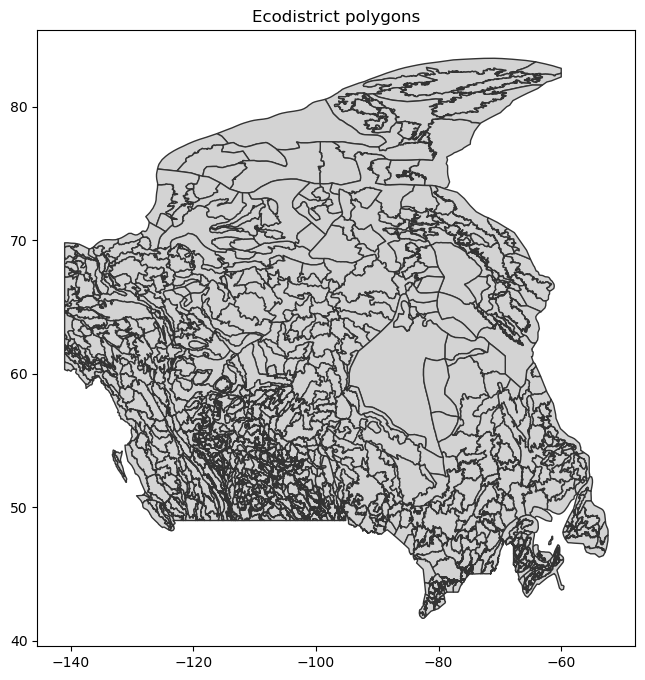

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
dissolved_polygons.plot(ax=ax, edgecolor="0.2", color='lightgrey')
# gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("Ecodistrict polygons")
plt.show()

In [46]:
dissolved_polygons.to_file("../data/external/slc_dissolved_ecodistrict/slc_dissolved_ecodistrict.shp")

In [43]:
ecodistrict = gpd.read_file("../data/external/slc_dissolved_ecodistrict")
ecodistrict = slc_polygons.to_crs('EPSG:4326')
ecodistrict

,AREA,PERIMETER,POLY_ID,ECO_ID,geometry
0,1.376666,6.159230,14003,14,"POLYGON ((-73.74820 83.60566, -72.61377 83.626..."
1,1.580340,9.611541,14002,14,"POLYGON ((-70.91842 83.63315, -69.65201 83.612..."
2,0.932502,5.332157,14004,14,"POLYGON ((-75.75444 83.56109, -74.13673 83.597..."
3,2.408007,13.902721,14005,14,"POLYGON ((-77.61654 83.51138, -76.16966 83.550..."
4,3.511283,27.056163,14001,14,"POLYGON ((-67.62450 83.54608, -65.74776 83.467..."
...,...,...,...,...,...
12348,0.011228,1.038751,572002,572,"POLYGON ((-82.62274 42.09282, -82.62270 42.093..."
12349,0.028866,0.843499,572004,572,"POLYGON ((-82.75051 42.03226, -82.74742 42.031..."
12350,0.019782,0.745984,572006,572,"POLYGON ((-82.86602 42.03530, -82.86598 42.033..."
12351,0.087583,1.234050,572005,572,"POLYGON ((-82.57620 41.88860, -82.57074 41.950..."


In [62]:
import random

In [97]:
# Function to generate random points within a polygon
def generate_random_points(polygon, num_points):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(polygon):  # Check if point is within the polygon
            points.append(random_point)
    return points

# # Specify the number of random points you want per polygon
# num_points_per_polygon = 5  # Adjust as needed


# # Generate the random points
# slc_polygons['random_points'] = slc_polygons['geometry'].apply(lambda x: generate_random_points(x, num_points_per_polygon))

# # If you want to extract and save latitude and longitude
def extract_lat_lon(points):
    return [(point.x, point.y) for point in points]

# # Extract latitude and longitude
# slc_polygons['lat_lon'] = slc_polygons['random_points'].apply(extract_lat_lon)


In [98]:
eco_id = 572
farm_ecodistrict = dissolved_polygons.query(f"ECO_ID == {eco_id}")
farm_ecodistrict_geometry = farm_ecodistrict["geometry"].iloc[0]
type(farm_ecodistrict_geometry)

shapely.geometry.polygon.Polygon

In [99]:
farm_ecodistrict

,ECO_ID,geometry,AREA,PERIMETER
568,572,"POLYGON ((-82.57620 41.88860, -82.57074 41.950...",0.031825,1.335354


In [100]:
min_x, min_y, max_x, max_y = farm_ecodistrict_geometry.bounds
print(min_x, min_y, max_x, max_y)

-83.15001777832535 41.67353655459526 -82.21088503725717 42.150007557059176


In [102]:
random_points = generate_random_points(farm_ecodistrict_geometry, 10)
# random_points
geo_series_points = gpd.GeoSeries(random_points)
print(geo_series_points)

0    POINT (-82.48585 41.68568)
1    POINT (-82.82712 42.01145)
2    POINT (-82.28125 41.82947)
3    POINT (-82.49747 41.80220)
4    POINT (-82.56403 41.83849)
5    POINT (-82.60266 41.75550)
6    POINT (-82.92900 41.94576)
7    POINT (-82.64636 41.86724)
8    POINT (-82.87381 41.84561)
9    POINT (-82.85285 41.97800)
dtype: geometry


In [103]:
extract_lat_lon(geo_series_points)

[(-82.48584690179675, 41.685681289071304),
 (-82.82711808758052, 42.0114457853692),
 (-82.28125120207335, 41.829465995421344),
 (-82.49746626387146, 41.802196462028334),
 (-82.56402794869797, 41.83848610258488),
 (-82.60266170444017, 41.755495140774386),
 (-82.9290032060646, 41.945756942074155),
 (-82.64636373094974, 41.86724048834937),
 (-82.87381239817465, 41.84560855160261),
 (-82.85285409211065, 41.978001831366484)]

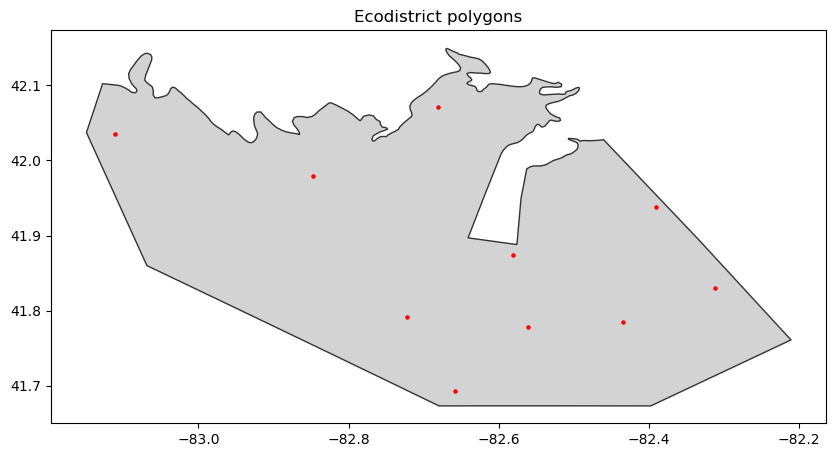

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
dissolved_polygons.query("ECO_ID == 572").plot(ax=ax, edgecolor="0.2", color='lightgrey')
geo_series_points.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("Ecodistrict polygons")
plt.show()

In [105]:
dissolved_polygons[["ECO_ID", "geometry"]]

,ECO_ID,geometry
0,1,"POLYGON ((-81.82100 80.84613, -81.86701 80.842..."
1,2,"POLYGON ((-78.14311 79.33501, -78.24853 79.337..."
2,3,"POLYGON ((-91.08031 79.05304, -91.07503 79.030..."
3,4,"POLYGON ((-82.29263 74.51720, -82.27618 74.542..."
4,5,"POLYGON ((-74.21592 71.20401, -74.22913 71.201..."
...,...,...
1022,9607,"POLYGON ((-113.82061 57.83890, -113.81799 57.8..."
1023,9608,"POLYGON ((-111.66100 56.61017, -111.66929 56.6..."
1024,9609,"POLYGON ((-111.75039 55.09389, -111.73839 55.0..."
1025,9687,"POLYGON ((-111.95540 53.80763, -111.96202 53.8..."


In [107]:
gdf

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919)
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613)
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464)
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513)
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653)
...,...,...,...,...,...,...,...,...,...,...
118,3531b218-e6c0-11ee-a6cc-0242ac150002,Canada,43.717398,-79.625701,c2a9b4d8-e6c0-11ee-bb98-0242ac150002,farm_site_boundary,24.0,"[{""lat"": 43.71732145136963, ""lng"": -79.6257741...",POLYGON ((-79.62577411476846 43.71732145136963...,POINT (-79.62570 43.71740)
119,2a03cf4c-e9e6-11ee-8667-0242ac150002,Canada,49.199923,-119.762455,ea56dbf4-e9e6-11ee-a60c-0242ac150002,farm_site_boundary,28408.0,"[{""lat"": 49.19914065991467, ""lng"": -119.760416...",POLYGON ((-119.7604163211487 49.19914065991467...,POINT (-119.76245 49.19992)
120,4316e7b6-eb90-11ee-807f-0242ac150002,Canada,51.272857,-120.173324,55a9d620-eb92-11ee-99a2-0242ac150002,farm_site_boundary,540627.0,"[{""lat"": 51.265569531243116, ""lng"": -120.16681...",POLYGON ((-120.1668140838416 51.26556953124311...,POINT (-120.17332 51.27286)
121,4316e7b6-eb90-11ee-807f-0242ac150002,Canada,51.272857,-120.173324,1525ee9e-eb93-11ee-871f-0242ac150002,farm_site_boundary,1677.0,"[{""lat"": 51.27113899369368, ""lng"": -120.169428...",POLYGON ((-120.16942815232515 51.2711389936936...,POINT (-120.17332 51.27286)


In [106]:
farm_polygons = gpd.sjoin(gdf, 
                          dissolved_polygons[["ECO_ID", "geometry"]],
                          how='left', 
                          predicate='within'
                         ).drop(columns=['index_right'])
farm_polygons.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,ECO_ID
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),959
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),959
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),562
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),458
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),540


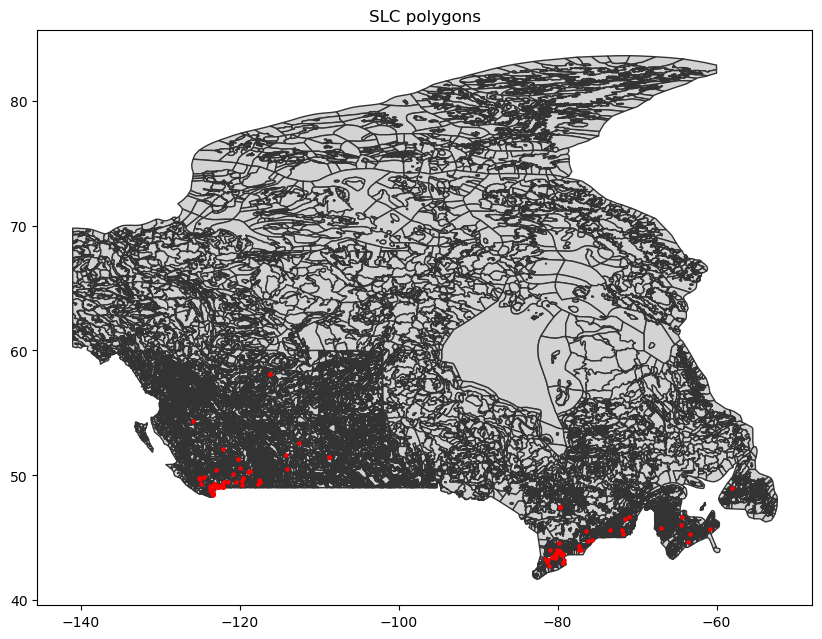

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
slc_polygons.plot(ax=ax, edgecolor="0.2", color='lightgrey')
# ax.set_aspect('equal')
gdf.set_geometry('point_geometry', inplace=True)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("SLC polygons")
plt.show()

In [8]:
farm_polygons = gpd.sjoin(gdf, 
                          slc_polygons[["POLY_ID", "ECO_ID", "geometry"]],
                          how='left', 
                          predicate='within'
                         ).drop(columns=['index_right'])
farm_polygons.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,POLY_ID,ECO_ID
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),959010,959
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),959010,959
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),562002,562
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),458007,458
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),540095,540


In [9]:
climate = pd.read_csv("../data/raw/Holos/ecodistrict_to_ecozone_mapping.csv")
climate.head()

,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,358,Boreal Shield West,Manitoba,348,453,0.00,Brown Chernozem,Coarse
1,358,Boreal Shield West,Saskatchewan,348,453,0.00,Brown Chernozem,Coarse
2,371,Boreal Shield West,Manitoba,376,581,0.33,Black/Gray Chernozem,Fine
3,371,Boreal Shield West,Ontario,376,581,0.33,Eastern Canada,Fine
4,375,Boreal Shield West,Manitoba,411,579,0.33,Black/Gray Chernozem,Fine


In [105]:
climate["SoilType"].unique()

array(['Brown Chernozem', 'Black/Gray Chernozem', 'Eastern Canada',
       'Dark Brown Chernozem'], dtype=object)

In [83]:
climate["Province"].unique()

array(['Manitoba', 'Saskatchewan', 'Ontario', 'Quebec',
       'Newfoundland and Labrador', 'New Brunswick', 'Nova Scotia',
       'Prince Edward Island', 'Alberta', 'British Columbia'],
      dtype=object)

In [10]:
holos_ecodistrict = climate["Ecodistrict"].unique().tolist()
farms_ecodistrict = farm_polygons["ECO_ID"].unique().tolist()

all_elements_contained = set(farms_ecodistrict).issubset(holos_ecodistrict)
print(all_elements_contained)

True


In [11]:
provinces = gpd.read_file("../data/external/provinces_shp")
provinces = provinces.to_crs("EPSG:4326") 
provinces.head()

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((-57.40256 54.14965, -57.38429 ..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((-61.98300 46.45775, -61.98136 ..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((-61.90233 45.87878, -61.90057 ..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((-64.80155 47.80365, -64.80155 ..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((-58.64703 51.20816, -58.63991 ..."


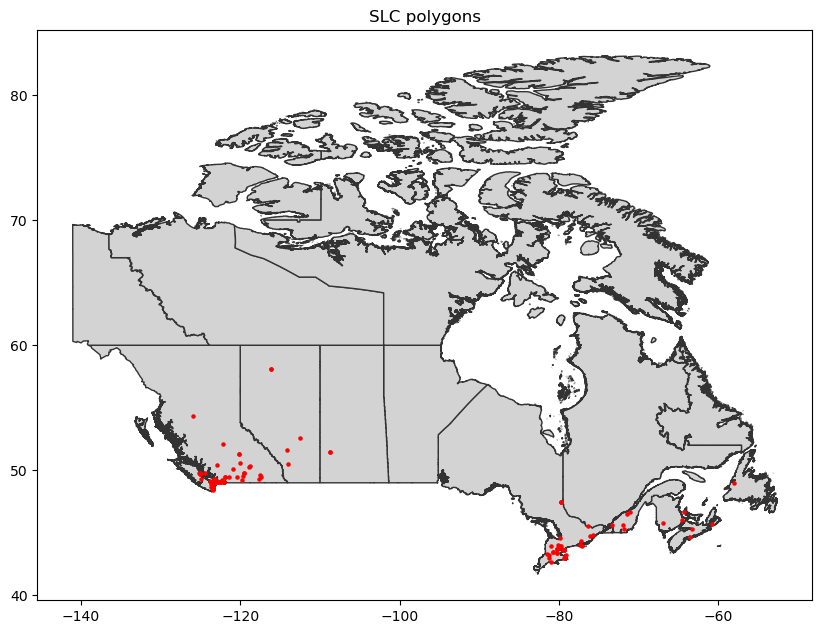

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
provinces.plot(ax=ax, edgecolor="0.2", color='lightgrey')
# ax.set_aspect('equal')
gdf.set_geometry('point_geometry', inplace=True)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("SLC polygons")
plt.show()

In [13]:
# Add province column 
farm_polygons = farm_polygons.to_crs("EPSG:4326") 
farm_polygons.set_geometry('point_geometry', inplace=True)
farm_eco_prov = gpd.sjoin(farm_polygons,
                          provinces[["PRENAME", "geometry"]], 
                          how='left', 
                          predicate='intersects'
                          ).drop(columns=['index_right'])

In [14]:
farm_eco_prov.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,POLY_ID,ECO_ID,PRENAME
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),959010,959,British Columbia
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),959010,959,British Columbia
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),562002,562,Ontario
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),458007,458,Newfoundland and Labrador
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),540095,540,Quebec


In [15]:
farm_prov = farm_eco_prov["PRENAME"].unique().tolist()
climate_prov = climate["Province"].unique().tolist()

all_province_contained = set(climate_prov).issubset(farm_prov)
print(all_elements_contained)

True


In [16]:
farm_ecoid_climate = pd.merge(farm_eco_prov, climate,  
                              how='left', 
                              left_on=['ECO_ID','PRENAME'], 
                              right_on = ['Ecodistrict','Province'])


In [17]:
farm_ecoid_climate.head()

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,...,ECO_ID,PRENAME,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),...,959,British Columbia,959,Pacific Maritime,British Columbia,480,506,6.53,Brown Chernozem,Medium
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),...,959,British Columbia,959,Pacific Maritime,British Columbia,480,506,6.53,Brown Chernozem,Medium
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),...,562,Ontario,562,Mixedwood Plains,Ontario,461,586,2.03,Eastern Canada,Medium
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),...,458,Newfoundland and Labrador,458,Boreal Shield East,Newfoundland and Labrador,621,407,0.00,Eastern Canada,Medium
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),...,540,Quebec,540,Mixedwood Plains,Quebec,652,556,11.71,Eastern Canada,Coarse


In [18]:
farm_ecoid_climate.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   farm_id               123 non-null    object  
 1   country_name          123 non-null    object  
 2   latitude              123 non-null    float64 
 3   longitude             123 non-null    float64 
 4   location_id           123 non-null    object  
 5   type                  123 non-null    object  
 6   location_area_m2      123 non-null    float64 
 7   location_grid_points  123 non-null    object  
 8   polygon_geometry      123 non-null    object  
 9   point_geometry        123 non-null    geometry
 10  POLY_ID               123 non-null    int64   
 11  ECO_ID                123 non-null    int64   
 12  PRENAME               123 non-null    object  
 13  Ecodistrict           123 non-null    int64   
 14  Ecozone               123 non-null    object  
 15

In [20]:
# Link polygons's climate data
polygon_climate = pd.read_csv("../data/raw/Holos/climateNorms_by_poly_1980_2010.csv")
polygon_climate.head()

,SLC,month,Tavg,PREC,PET
0,1001009,1,-4.435724,36.944946,0.000872
1,1001009,2,-1.590094,19.551792,0.145423
2,1001009,3,2.747708,20.984373,12.787213
3,1001009,4,7.378428,17.094301,58.751700
4,1001009,5,12.121925,27.899176,106.848321


In [22]:
pl_1001009 = polygon_climate.query("SLC == 1001009")
pl_1001009

,SLC,month,Tavg,PREC,PET
0,1001009,1,-4.435724,36.944946,0.000872
1,1001009,2,-1.590094,19.551792,0.145423
2,1001009,3,2.747708,20.984373,12.787213
3,1001009,4,7.378428,17.094301,58.751700
4,1001009,5,12.121925,27.899176,106.848321
5,1001009,6,16.009086,34.396989,128.145210
6,1001009,7,19.401106,27.869427,151.593087
7,1001009,8,19.009205,23.902975,132.828566
8,1001009,9,14.085603,26.408781,74.659855
9,1001009,10,7.280513,31.575018,14.059718


In [27]:
filtered_pc = polygon_climate.query("5<= month <= 10")
# filtered_pc.describe()

,SLC,month,Tavg,PREC,PET
count,2.245800e+04,22458.000000,22458.000000,22458.000000,22458.000000
mean,7.091457e+05,7.500000,13.969134,62.907452,89.009041
std,7.395539e+05,1.707863,4.824506,26.266514,41.569430
min,2.440070e+05,5.000000,0.000000,0.000000,0.000000
25%,5.130120e+05,6.000000,10.671465,40.453367,59.101862
50%,5.990010e+05,7.500000,14.840184,63.400732,102.501236
75%,7.800050e+05,9.000000,17.906792,83.541532,122.045830
max,9.787004e+06,10.000000,24.350927,234.475000,169.746832


In [29]:
sum_prec_by_polyid = filtered_pc.groupby('SLC').agg({
    'PREC': 'sum',
    'PET': 'sum'
}).reset_index()
sum_prec_by_polyid.head()

,SLC,PREC,PET
0,244007,309.691331,462.468366
1,244052,219.848583,455.783519
2,244058,221.149380,444.250239
3,244061,210.919931,428.387693
4,244066,250.853528,414.068376


In [30]:
sum_prec_by_polyid.query("SLC == 1001009")

,SLC,PREC,PET
3565,1001009,172.052366,608.134756


In [31]:
sum_prec_by_polyid["SLC"]

0        244007
1        244052
2        244058
3        244061
4        244066
         ...   
3738    9687011
3739    9787001
3740    9787002
3741    9787003
3742    9787004
Name: SLC, Length: 3743, dtype: int64

In [32]:
farm_ecoid_polyid_climate = pd.merge(farm_ecoid_climate, sum_prec_by_polyid,
                                     how='left',
                                     left_on=['POLY_ID'],
                                     right_on = ['SLC'])
farm_ecoid_polyid_climate

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,...,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture,SLC,PREC,PET
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),...,Pacific Maritime,British Columbia,480,506,6.53,Brown Chernozem,Medium,959010.0,437.677973,479.233490
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),...,Pacific Maritime,British Columbia,480,506,6.53,Brown Chernozem,Medium,959010.0,437.677973,479.233490
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),...,Mixedwood Plains,Ontario,461,586,2.03,Eastern Canada,Medium,562002.0,422.976129,582.440456
3,1e3b98f8-ca44-11eb-8062-0242ac130002,Canada,48.995126,-58.045602,5f708a3c-ca5c-11eb-a595-0242ac130002,farm_site_boundary,1047.0,"[{""lat"": 48.994851525201184, ""lng"": -58.045751...",POLYGON ((-58.04575132181069 48.99485152520118...,POINT (-58.04560 48.99513),...,Boreal Shield East,Newfoundland and Labrador,621,407,0.00,Eastern Canada,Medium,458007.0,541.025731,383.361178
4,33851eae-dad5-11eb-9c2f-0242ac130002,Canada,46.636528,-71.042723,fcc4ed58-dad5-11eb-b818-0242ac130002,farm_site_boundary,52718.0,"[{""lat"": 46.63706792013167, ""lng"": -71.0435030...",POLYGON ((-71.04350309594241 46.63706792013167...,POINT (-71.04272 46.63653),...,Mixedwood Plains,Quebec,652,556,11.71,Eastern Canada,Coarse,540095.0,637.060645,529.619822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,3531b218-e6c0-11ee-a6cc-0242ac150002,Canada,43.717398,-79.625701,c2a9b4d8-e6c0-11ee-bb98-0242ac150002,farm_site_boundary,24.0,"[{""lat"": 43.71732145136963, ""lng"": -79.6257741...",POLYGON ((-79.62577411476846 43.71732145136963...,POINT (-79.62570 43.71740),...,Mixedwood Plains,Ontario,461,586,2.03,Eastern Canada,Medium,562001.0,413.929167,578.030789
119,2a03cf4c-e9e6-11ee-8667-0242ac150002,Canada,49.199923,-119.762455,ea56dbf4-e9e6-11ee-a60c-0242ac150002,farm_site_boundary,28408.0,"[{""lat"": 49.19914065991467, ""lng"": -119.760416...",POLYGON ((-119.7604163211487 49.19914065991467...,POINT (-119.76245 49.19992),...,Montane Cordillera,British Columbia,222,683,5.82,Brown Chernozem,Medium,1009013.0,176.254193,637.867651
120,4316e7b6-eb90-11ee-807f-0242ac150002,Canada,51.272857,-120.173324,55a9d620-eb92-11ee-99a2-0242ac150002,farm_site_boundary,540627.0,"[{""lat"": 51.265569531243116, ""lng"": -120.16681...",POLYGON ((-120.1668140838416 51.26556953124311...,POINT (-120.17332 51.27286),...,Montane Cordillera,British Columbia,159,678,7.57,Black/Gray Chernozem,Medium,1004023.0,313.606774,592.274522
121,4316e7b6-eb90-11ee-807f-0242ac150002,Canada,51.272857,-120.173324,1525ee9e-eb93-11ee-871f-0242ac150002,farm_site_boundary,1677.0,"[{""lat"": 51.27113899369368, ""lng"": -120.169428...",POLYGON ((-120.16942815232515 51.2711389936936...,POINT (-120.17332 51.27286),...,Montane Cordillera,British Columbia,159,678,7.57,Black/Gray Chernozem,Medium,1004023.0,313.606774,592.274522


In [39]:
farm_ecoid_polyid_climate.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   farm_id               123 non-null    object  
 1   country_name          123 non-null    object  
 2   latitude              123 non-null    float64 
 3   longitude             123 non-null    float64 
 4   location_id           123 non-null    object  
 5   type                  123 non-null    object  
 6   location_area_m2      123 non-null    float64 
 7   location_grid_points  123 non-null    object  
 8   polygon_geometry      123 non-null    object  
 9   point_geometry        123 non-null    geometry
 10  POLY_ID               123 non-null    int64   
 11  ECO_ID                123 non-null    int64   
 12  PRENAME               123 non-null    object  
 13  Ecodistrict           123 non-null    int64   
 14  Ecozone               123 non-null    object  
 15

In [42]:
na_rows = farm_ecoid_polyid_climate[farm_ecoid_polyid_climate.isna().any(axis=1)]
na_rows["POLY_ID"]

80    951017
92    951017
Name: POLY_ID, dtype: int64

In [43]:
polygon_climate.query("SLC == 951017")

,SLC,month,Tavg,PREC,PET


In [33]:
farm_ecoid_polyid_climate["P_diff"] = farm_ecoid_polyid_climate["PMayToOct"] - farm_ecoid_polyid_climate["PREC"]
farm_ecoid_polyid_climate["PE_diff"] = farm_ecoid_polyid_climate["PEMayToOct"] - farm_ecoid_polyid_climate["PET"]

In [38]:
farm_ecoid_polyid_climate[["PMayToOct", "PREC", "P_diff", "PEMayToOct", "PET", "PE_diff"]].describe()

,PMayToOct,PREC,P_diff,PEMayToOct,PET,PE_diff
count,123.000000,121.000000,121.000000,123.000000,121.000000,121.000000
mean,424.707317,397.474164,27.757241,531.349593,520.198923,12.941573
std,119.307066,115.156352,62.365400,69.717578,61.840801,42.400336
min,159.000000,163.521183,-154.606774,404.000000,383.361178,-84.050174
25%,318.000000,282.706210,11.139758,506.000000,463.185872,-16.734712
50%,480.000000,429.802803,44.731613,529.000000,522.734712,12.510851
75%,490.000000,460.786452,68.508387,583.500000,572.312346,39.459944
max,665.000000,637.060645,179.138790,683.000000,660.811751,152.669213


In [47]:
farm_ecoid_polyid_climate.query("Province == 'British Columbia'")

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,...,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture,SLC,PREC,PET,P_diff,PE_diff
0,7a2e6fcc-ab78-11eb-a4ad-0242ac130002,Canada,49.059192,-122.882005,605c6008-ab7e-11eb-8a94-0242ac130002,farm_site_boundary,211908.0,"[{""lat"": 49.05928816695972, ""lng"": -122.883487...",POLYGON ((-122.88348775768395 49.0592881669597...,POINT (-122.88200 49.05919),...,480,506,6.53,Brown Chernozem,Medium,959010.0,437.677973,479.233490,42.322027,26.766510
1,36322d78-b2ac-11eb-9edf-0242ac130002,Canada,49.036135,-122.713490,931eeb88-b2ad-11eb-b6ac-0242ac130002,farm_site_boundary,21388.0,"[{""lat"": 49.0361106915654, ""lng"": -122.7183954...",POLYGON ((-122.71839542729994 49.0361106915654...,POINT (-122.71349 49.03613),...,480,506,6.53,Brown Chernozem,Medium,959010.0,437.677973,479.233490,42.322027,26.766510
5,742f9fee-e1d6-11eb-9c8c-0242ac130002,Canada,48.670856,-123.538603,a0ceeb12-e1d7-11eb-aa9b-0242ac130002,farm_site_boundary,12256.0,"[{""lat"": 48.670913997111604, ""lng"": -123.53951...",POLYGON ((-123.53951675636091 48.6709139971116...,POINT (-123.53860 48.67086),...,318,428,4.68,Brown Chernozem,Fine,956018.0,257.014946,454.302900,60.985054,-26.302900
6,c6cd4bda-e4e1-11eb-ab2c-0242ac130002,Canada,49.636176,-117.552104,a1b6e5e0-e4e6-11eb-9249-0242ac130002,farm_site_boundary,22560.0,"[{""lat"": 49.63557408952363, ""lng"": -117.553154...",POLYGON ((-117.55315457412514 49.6355740895236...,POINT (-117.55210 49.63618),...,321,554,16.82,Brown Chernozem,Medium,990031.0,313.408226,566.928571,7.591774,-12.928571
7,a238c0d0-f26d-11eb-9950-0242ac140002,Canada,49.674478,-125.030860,afb18e2c-f272-11eb-9997-0242ac140002,farm_site_boundary,8415.0,"[{""lat"": 49.673345599316406, ""lng"": -125.03268...",POLYGON ((-125.03268688440619 49.6733455993164...,POINT (-125.03086 49.67448),...,318,428,4.68,Brown Chernozem,Fine,956005.0,393.699917,470.261462,-75.699917,-42.261462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,45a878dc-cd1d-11ee-a3f1-0242ac150002,Canada,49.132540,-123.756250,276bc5ae-d8df-11ee-b5ed-0242ac150002,farm_site_boundary,79634.0,"[{""lat"": 49.13032656100895, ""lng"": -123.761933...",POLYGON ((-123.76193317279174 49.1303265610089...,POINT (-123.75625 49.13254),...,387,405,11.01,Brown Chernozem,Medium,957014.0,293.397742,457.859974,93.602258,-52.859974
119,2a03cf4c-e9e6-11ee-8667-0242ac150002,Canada,49.199923,-119.762455,ea56dbf4-e9e6-11ee-a60c-0242ac150002,farm_site_boundary,28408.0,"[{""lat"": 49.19914065991467, ""lng"": -119.760416...",POLYGON ((-119.7604163211487 49.19914065991467...,POINT (-119.76245 49.19992),...,222,683,5.82,Brown Chernozem,Medium,1009013.0,176.254193,637.867651,45.745807,45.132349
120,4316e7b6-eb90-11ee-807f-0242ac150002,Canada,51.272857,-120.173324,55a9d620-eb92-11ee-99a2-0242ac150002,farm_site_boundary,540627.0,"[{""lat"": 51.265569531243116, ""lng"": -120.16681...",POLYGON ((-120.1668140838416 51.26556953124311...,POINT (-120.17332 51.27286),...,159,678,7.57,Black/Gray Chernozem,Medium,1004023.0,313.606774,592.274522,-154.606774,85.725478
121,4316e7b6-eb90-11ee-807f-0242ac150002,Canada,51.272857,-120.173324,1525ee9e-eb93-11ee-871f-0242ac150002,farm_site_boundary,1677.0,"[{""lat"": 51.27113899369368, ""lng"": -120.169428...",POLYGON ((-120.16942815232515 51.2711389936936...,POINT (-120.17332 51.27286),...,159,678,7.57,Black/Gray Chernozem,Medium,1004023.0,313.606774,592.274522,-154.606774,85.725478


In [49]:
p = 159
pe = 678
f_topo = 7.57

In [75]:
import math
ef_ct_1 = math.exp(0.00558*p - 7.7) * 100
ef_ct_2 = math.exp(0.00558*pe - 7.7) * 100

In [76]:
ef_ct_1

0.1099631670775916

In [77]:
ef_ct_2

1.9905484145844587

In [78]:
ef_ct_2  * f_topo / 100 + ef_ct_1 * (1 - f_topo/100)

0.25232347031386143

In [59]:
ef_ct_1  * 50 / 100 + ef_ct_2 * (1 - 50/100)

1.0502557908310253

In [81]:
farm_ecoid_polyid_climate["Province"].unique()

array(['British Columbia', 'Ontario', 'Newfoundland and Labrador',
       'Quebec', 'Alberta', 'New Brunswick', 'Nova Scotia',
       'Saskatchewan', 'Prince Edward Island'], dtype=object)

In [82]:
climate["Province"].unique()

array(['Manitoba', 'Saskatchewan', 'Ontario', 'Quebec',
       'Newfoundland and Labrador', 'New Brunswick', 'Nova Scotia',
       'Prince Edward Island', 'Alberta', 'British Columbia'],
      dtype=object)

In [84]:
farm_ecoid_polyid_climate.query("Province == 'Ontario'")

,farm_id,country_name,latitude,longitude,location_id,type,location_area_m2,location_grid_points,polygon_geometry,point_geometry,...,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture,SLC,PREC,PET,P_diff,PE_diff
2,dee27326-b2af-11eb-a871-0242ac130002,Canada,43.944641,-79.730420,607eb4a8-b2b0-11eb-b10e-0242ac130002,farm_site_boundary,211695.0,"[{""lat"": 43.94351188354036, ""lng"": -79.7265726...",POLYGON ((-79.72657263766844 43.94351188354036...,POINT (-79.73042 43.94464),...,461,586,2.03,Eastern Canada,Medium,562002.0,422.976129,582.440456,38.023871,3.559544
20,b4dc8a4a-5899-11ec-a805-0242ac150004,Canada,43.211569,-81.243985,b5a77364-589d-11ec-b276-0242ac150004,farm_site_boundary,6995.0,"[{""lat"": 43.208806503070335, ""lng"": -81.243730...",POLYGON ((-81.24373086472684 43.20880650307033...,POINT (-81.24398 43.21157),...,526,589,2.23,Eastern Canada,Medium,557005.0,465.834505,584.411644,60.165495,4.588356
23,7c1fe092-70ab-11ec-bce9-0242ac150004,Canada,43.650131,-79.376157,35a2a680-70ac-11ec-afc8-0242ac150004,farm_site_boundary,33377.0,"[{""lat"": 43.8510816928134, ""lng"": -79.16810165...","POLYGON ((-79.16810165634944 43.8510816928134,...",POINT (-79.37616 43.65013),...,445,531,10.01,Eastern Canada,Medium,563001.0,400.268387,568.701415,44.731613,-37.701415
27,123d404a-8184-11ec-b625-0242ac150004,Canada,44.591560,-79.848285,8ba8f9b2-8187-11ec-a102-0242ac150004,farm_site_boundary,208890.0,"[{""lat"": 44.590986706200006, ""lng"": -79.849405...",POLYGON ((-79.84940581755193 44.59098670620000...,POINT (-79.84829 44.59156),...,505,541,6.42,Eastern Canada,Fine,551015.0,445.907742,560.557797,59.092258,-19.557797
35,25182038-a496-11ec-b6c6-0242ac150004,Canada,42.971893,-79.267689,70fb8994-a49c-11ec-8197-0242ac150004,farm_site_boundary,483.0,"[{""lat"": 42.97184534453459, ""lng"": -79.2679123...",POLYGON ((-79.26791230931563 42.97184534453459...,POINT (-79.26769 42.97189),...,490,568,15.60,Eastern Canada,Fine,569001.0,438.416562,548.123325,51.583438,19.876675
36,8ec4938c-a495-11ec-84ae-0242ac150004,Canada,42.983490,-79.377840,9a3016a2-a49e-11ec-b64f-0242ac150004,farm_site_boundary,17988.0,"[{""lat"": 42.983346465735636, ""lng"": -79.378462...",POLYGON ((-79.37846278094084 42.98334646573563...,POINT (-79.37784 42.98349),...,490,568,15.60,Eastern Canada,Fine,569001.0,438.416562,548.123325,51.583438,19.876675
37,409ffbd2-a5ef-11ec-829d-0242ac150004,Canada,43.290989,-81.520383,1820a71c-a5f2-11ec-829d-0242ac150004,farm_site_boundary,164513.0,"[{""lat"": 43.292414704920944, ""lng"": -81.520733...",POLYGON ((-81.52073370505165 43.29241470492094...,POINT (-81.52038 43.29099),...,526,589,2.23,Eastern Canada,Medium,557007.0,452.353226,589.146476,73.646774,-0.146476
38,4b39dbe8-a71c-11ec-8cf0-0242ac150004,Canada,44.338295,-77.269479,3ad9edb4-a71d-11ec-8690-0242ac150004,farm_site_boundary,319855.0,"[{""lat"": 44.338505927555296, ""lng"": -77.267705...",POLYGON ((-77.26770585018504 44.33850592755529...,POINT (-77.26948 44.33830),...,501,593,6.70,Eastern Canada,Medium,552001.0,438.165899,582.077188,62.834101,10.922812
39,8dbcf280-9e24-11ec-ba30-0242ac150004,Canada,43.679254,-80.252299,c07abc16-a9e6-11ec-9ee8-0242ac150004,farm_site_boundary,59363.0,"[{""lat"": 43.680394029116385, ""lng"": -80.252066...",POLYGON ((-80.25206647529978 43.68039402911638...,POINT (-80.25230 43.67925),...,490,601,9.79,Eastern Canada,Medium,560003.0,453.338735,582.809793,36.661265,18.190207
40,2fe062c0-a9fd-11ec-bf05-0242ac150004,Canada,47.458270,-79.717574,10481054-aa00-11ec-baf8-0242ac150004,farm_site_boundary,183.0,"[{""lat"": 47.46469060844838, ""lng"": -79.7160913...",POLYGON ((-79.71609134518427 47.46469060844838...,POINT (-79.71757 47.45827),...,478,571,2.99,Eastern Canada,Medium,408005.0,448.015161,540.146728,29.984839,30.853272


In [92]:
farm_ecoid_polyid_climate[["PMayToOct", "Ftopo", "PEMayToOct"]].describe()

,PMayToOct,Ftopo,PEMayToOct
count,123.000000,123.000000,123.000000
mean,424.707317,7.721463,531.349593
std,119.307066,5.881614,69.717578
min,159.000000,0.000000,404.000000
25%,318.000000,4.680000,506.000000
50%,480.000000,6.530000,529.000000
75%,490.000000,9.155000,583.500000
max,665.000000,33.560000,683.000000


In [93]:
polygon_climate.head()

,SLC,month,Tavg,PREC,PET
0,1001009,1,-4.435724,36.944946,0.000872
1,1001009,2,-1.590094,19.551792,0.145423
2,1001009,3,2.747708,20.984373,12.787213
3,1001009,4,7.378428,17.094301,58.751700
4,1001009,5,12.121925,27.899176,106.848321


In [97]:
poly1004023 = sum_prec_by_polyid.query("SLC == 1004023")

In [98]:
poly1004023

,SLC,PREC,PET
3583,1004023,313.606774,592.274522


In [100]:
polygon_climate

,SLC,month,Tavg,PREC,PET
0,1001009,1,-4.435724,36.944946,0.000872
1,1001009,2,-1.590094,19.551792,0.145423
2,1001009,3,2.747708,20.984373,12.787213
3,1001009,4,7.378428,17.094301,58.751700
4,1001009,5,12.121925,27.899176,106.848321
...,...,...,...,...,...
44911,992005,8,16.937637,28.405230,126.498266
44912,992005,9,11.580262,34.170442,66.449092
44913,992005,10,4.996441,33.238318,15.766264
44914,992005,11,-2.040643,52.727777,0.045651


In [102]:
slc_polygons.query("POLY_ID == 1004023")

,AREA,PERIMETER,POLY_ID,ECO_ID,geometry
7924,0.023754,1.513851,1004023,1004,"POLYGON ((-120.10112 51.64078, -120.09315 51.6..."


In [103]:
climate 

,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,358,Boreal Shield West,Manitoba,348,453,0.00,Brown Chernozem,Coarse
1,358,Boreal Shield West,Saskatchewan,348,453,0.00,Brown Chernozem,Coarse
2,371,Boreal Shield West,Manitoba,376,581,0.33,Black/Gray Chernozem,Fine
3,371,Boreal Shield West,Ontario,376,581,0.33,Eastern Canada,Fine
4,375,Boreal Shield West,Manitoba,411,579,0.33,Black/Gray Chernozem,Fine
...,...,...,...,...,...,...,...,...
464,1017,Montane Cordillera,Alberta,329,588,0.00,Black/Gray Chernozem,Medium
465,1017,Montane Cordillera,British Columbia,321,554,0.00,Black/Gray Chernozem,Medium
466,1018,Montane Cordillera,Alberta,326,574,12.62,Black/Gray Chernozem,Medium
467,1019,Montane Cordillera,Alberta,335,581,12.62,Black/Gray Chernozem,Medium


In [104]:
climate.query("Ecodistrict == 1004")

,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
452,1004,Montane Cordillera,British Columbia,159,678,7.57,Black/Gray Chernozem,Medium
